In [1]:
from collections import Counter
from dotenv import dotenv_values
from gpt4all import GPT4All
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import corpora, models, similarities
from gensim.models.ldamulticore import LdaMulticore
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from langdetect import detect, DetectorFactory
import matplotlib.pyplot as plt
import pandas as pd
from langchain_community.llms import GPT4All
import seaborn as sns
from matplotlib import cm
import numpy as np
from tqdm import tqdm
from wordcloud import WordCloud
import nest_asyncio
import praw
from sklearn.manifold import TSNE
import re
import string

nest_asyncio.apply()

nltk.download("vader_lexicon")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\raize\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

Reddit is the server that provides an API (Application Programming Interface).
PRAW is a Python library that acts as the client, meaning it communicates with Reddit's API on your behalf.

In [3]:
#env file has all the hidden credentials
config = dotenv_values(".env")

#reddit API praw library to collect r/<insert movie here> posts 
reddit = praw.Reddit(
    client_id = config['CLIENT_ID'],
    client_secret = config['CLIENT_SECRET'], 
    user_agent = config['USER_AGENT'],
)

In [4]:
def analyze_subreddits_sentiment(reddit_client, subreddits, post_limit=5000):
    global all_words, fdist, stopwords_list
    
    DetectorFactory.seed = 0  # make language detection deterministic
    vader = SentimentIntensityAnalyzer()
    
    # Prepare stopwords list
    additional_stopwords = ['https', 'i', 'com', 'http', 'rt', 'co', 'the', 'amp', 'lt', 'a', 'www', 'got', 'get', 
                            'ly', 'u', 'also', 'like', 'could', 'go', 'know', 'org', 'edu', 'cdn', 'img', 'jpg', 'png', 
                            'even','*']
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation) #adds punctuation if the punctuation was a token and not attached to a word
    stopwords_list += additional_stopwords
    stopwords_list = list(set([word.lower() for word in stopwords_list]))

    #from chatgpt because my stopwords list in the following function doesn't remove the puntuation properly
    #real tokenizer that separates punctuation from words
    def clean_and_tokenize(text):
        tokens = word_tokenize(text.lower())  # splits "version," into ["version", ","]
        tokens = [word for word in tokens if word.isalpha()]  # removes punctuation/numbers
        tokens = [word for word in tokens if word not in stopwords_list]
        return tokens

    combined_df = pd.DataFrame() #needed to accumulate all the dfs/movies that go through the for loop 
    all_words = []
    for subreddit_name in subreddits:
        subreddit = reddit_client.subreddit(subreddit_name)
        
        reviews = []
        for submission in subreddit.new(limit=post_limit):
            if submission.selftext:
                try:
                    if detect(submission.selftext) == 'en':
                        reviews.append(submission.selftext)
                except:
                    pass
        
        df = pd.DataFrame({'reviews': reviews})
        #column to show which subreddit the post pertains to 
        df['movie_subreddit'] = subreddit_name
        
        # Sentiment analysis with VADER
        df['positive_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['pos'])
        df['negative_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['neg'])
        df['neutral_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['neu'])
        df['compound_sentiment_score'] = df['reviews'].apply(lambda x: vader.polarity_scores(x)['compound'])

        def classify_sentiment(score):
            if score >= 0.05:
                return 'positive'
            elif score <= -0.05:
                return 'negative'
            else:
                return 'neutral'
        
        df['sentiment'] = df['compound_sentiment_score'].apply(classify_sentiment)
        
        # Clean and tokenize
        df["filtered_review"] = df["reviews"].apply(clean_and_tokenize)

        # Add to combined dataframe
        combined_df = pd.concat([combined_df, df], ignore_index=True)
        
    return combined_df

In [ ]:
# PRAW Reddit client called `reddit` as first argument
movie_subreddits = ['Inception', 'Wicked', 'ShawshankRedemption'] #'A Walk To Remember'
movies_df = analyze_subreddits_sentiment(reddit, movie_subreddits, post_limit=1000)

In [ ]:
movies_df.head(2)

In [ ]:
def freq_dist_for_group(group):
    global fdist, all_words #use object for graphs
    all_words = group['filtered_review'].explode() #takes tokens into a series 
    fdist = FreqDist(all_words) #NLTKs FreqDist counts how many times each word appears
    return fdist #dictionary 

fdist_series = movies_df.groupby('movie_subreddit').apply(freq_dist_for_group)

In [ ]:
fdist_series
# fdist
# all_words[:7]

In [ ]:
for movie in movie_subreddits:
    fdist_movie = fdist_series[movie].most_common(10)
    print(fdist_movie)

In [12]:
movie_subreddits = ['Inception', 'Wicked', 'ShawshankRedemption']
movie_name_df = pd.DataFrame() #needed to accumulate all the dfs/movies that go through the for loop 
for movie in movie_subreddits:
    each_movie_df = movies_df[movies_df['movie_subreddit'] == movie]
    movie_name_df = pd.concat([movie_name_df, each_movie_df], ignore_index=True)
movie_name_df.head(2)

,reviews,movie_subreddit,positive_sentiment_score,negative_sentiment_score,neutral_sentiment_score,compound_sentiment_score,sentiment,filtered_review
0,So I was thinking about the fact that dreams a...,Inception,0.128,0.020,0.852,0.9178,positive,"[thinking, fact, dreams, lot, less, consistent..."
1,How much of the dream is remembered by the dre...,Inception,0.094,0.034,0.872,0.8862,positive,"[much, dream, remembered, dreamers, fischer, c..."


In [13]:
movie_name_df.shape
movie_name_df['movie_subreddit'].value_counts()

movie_subreddit
Wicked                 652
Inception              496
ShawshankRedemption     79
Name: count, dtype: int64

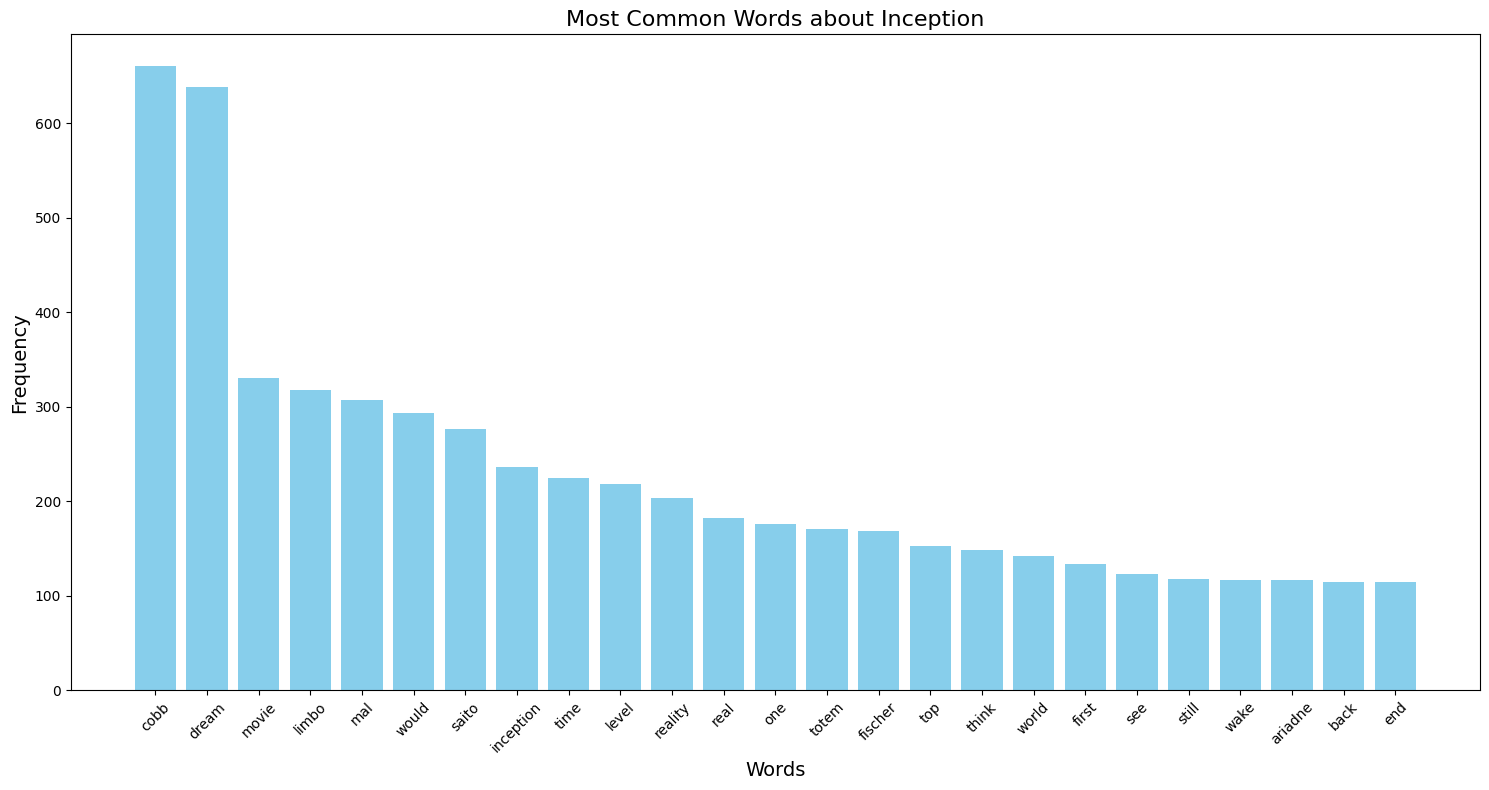

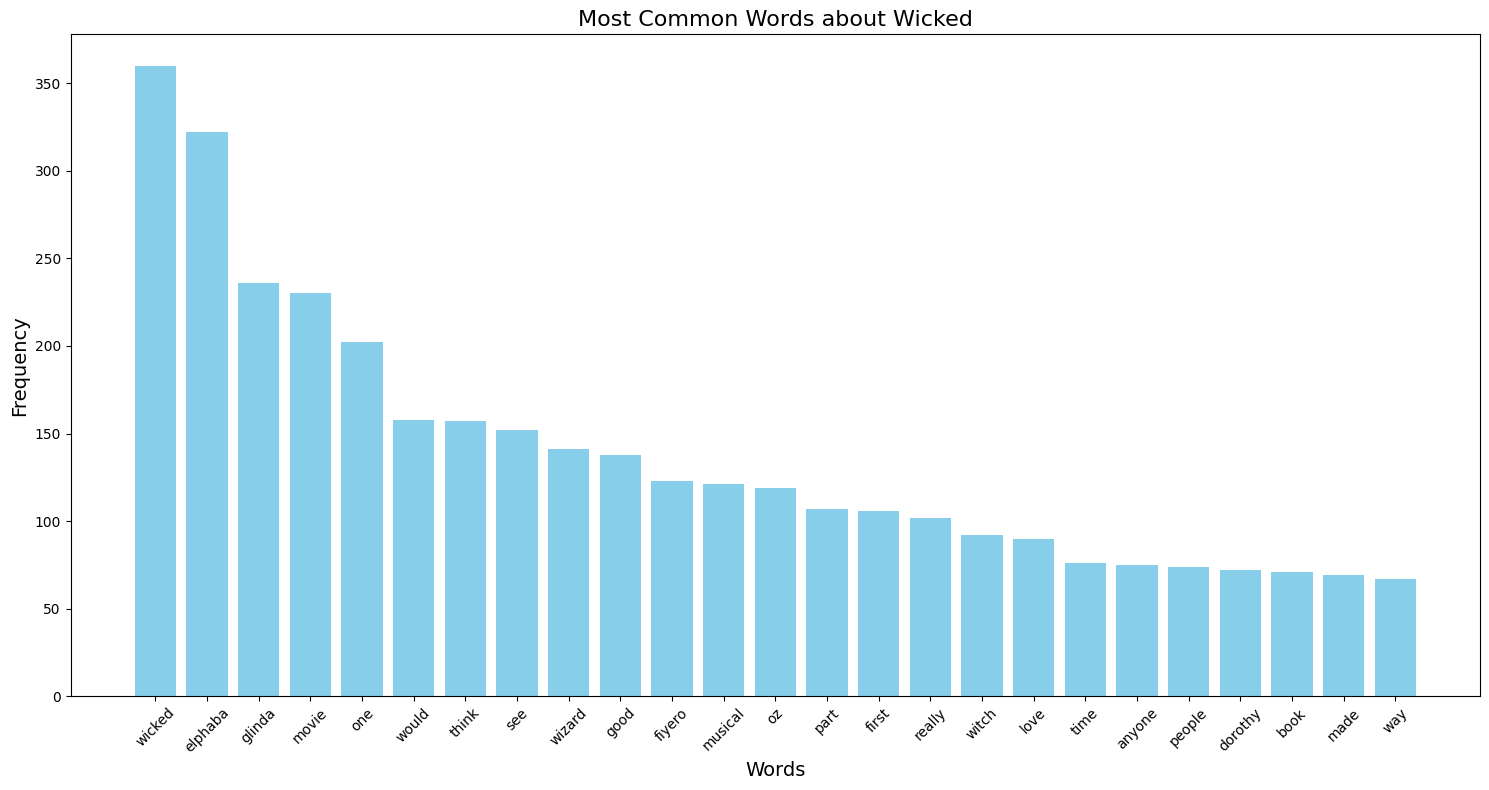

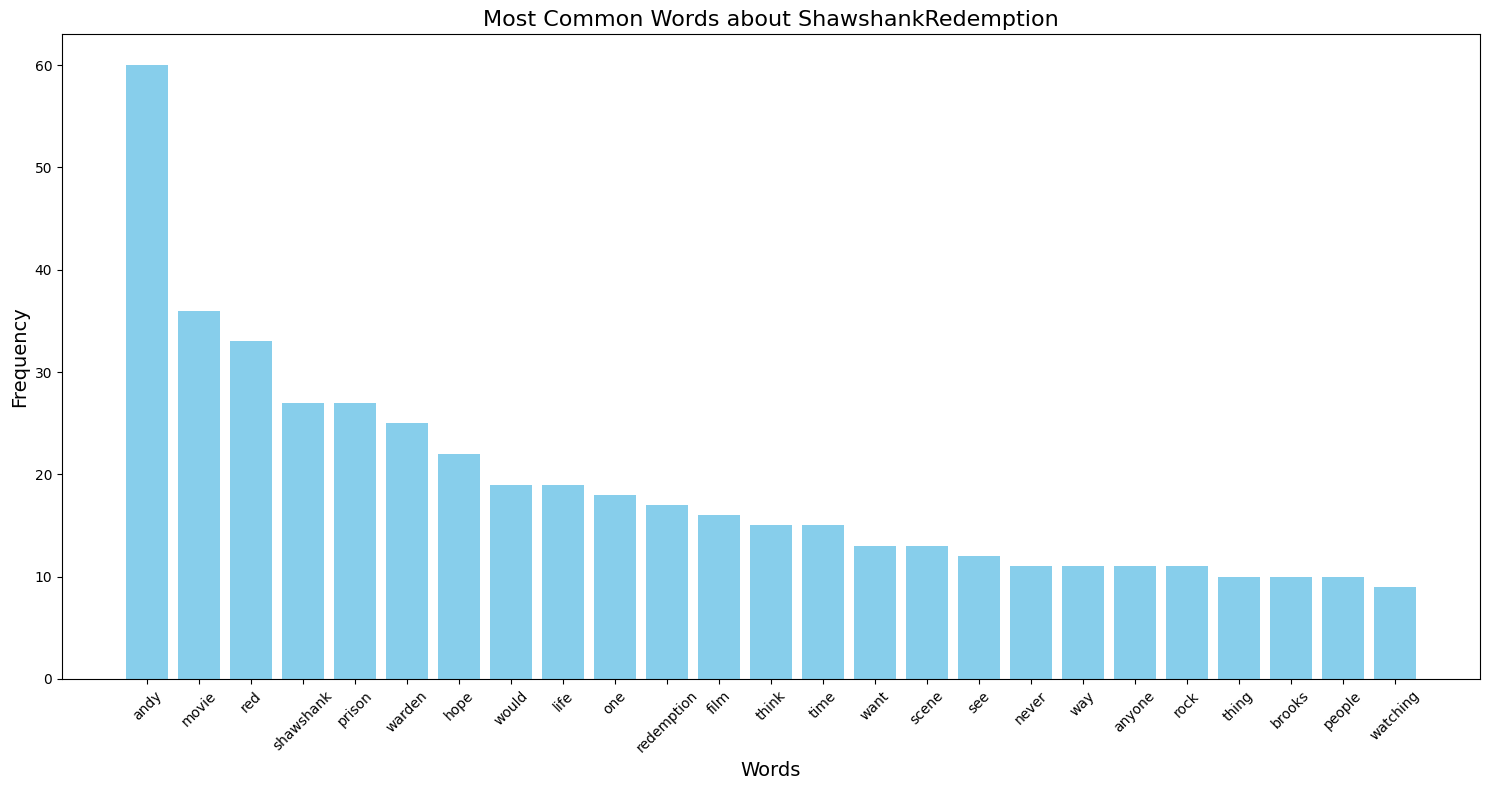

In [16]:
for movie in movie_subreddits:
    fdist_movie = fdist_series[movie].most_common(25)  # top 25 words
    
    # Separate words and counts for plotting
    words, counts = zip(*fdist_movie)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.bar(words, counts, color='skyblue')
    ax.set_title(f"Most Common Words about {movie}", fontsize=16)
    ax.set_xlabel("Words", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig('images/' + movie + '_freqbargraph.png')
    plt.show()

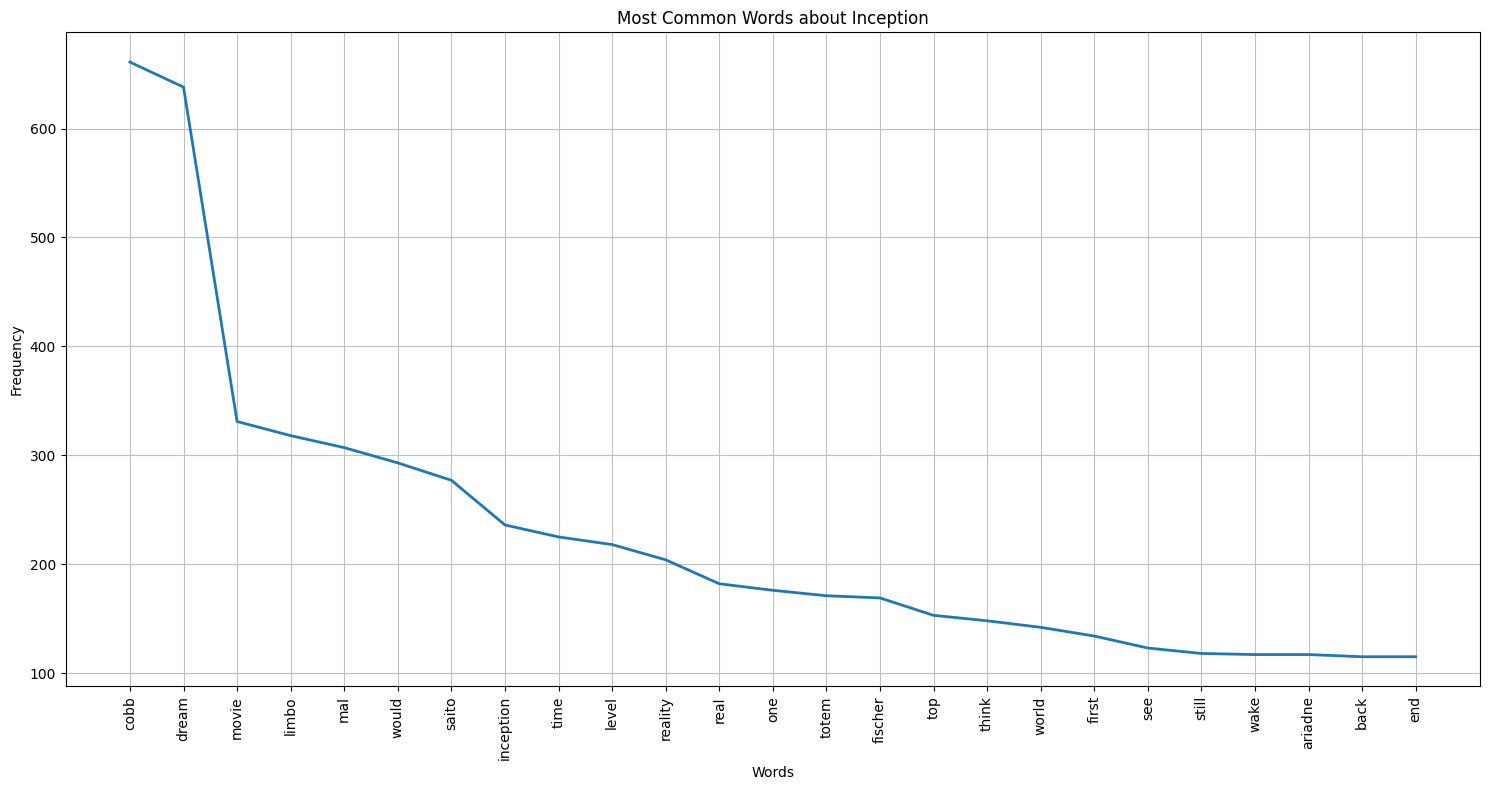

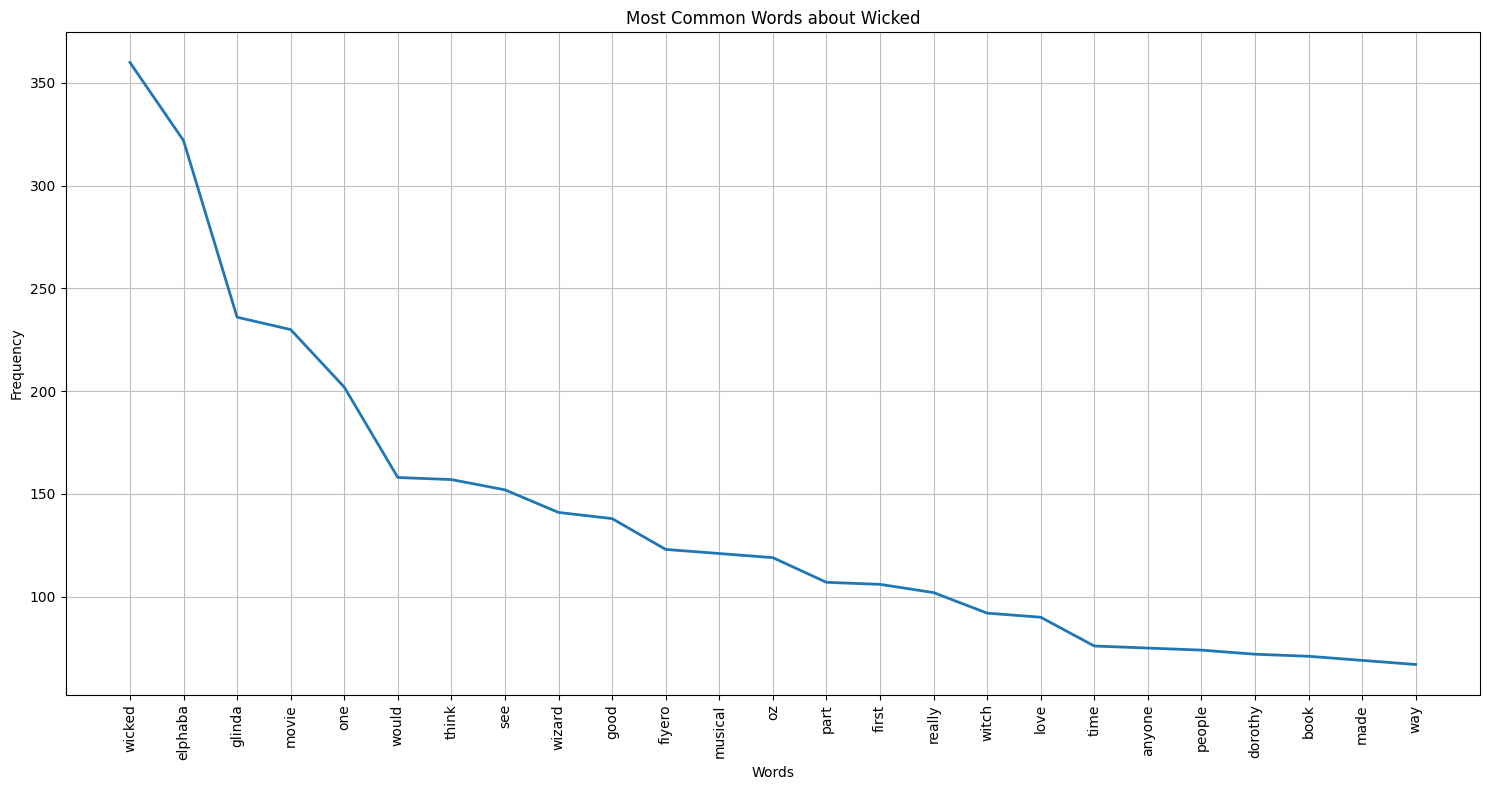

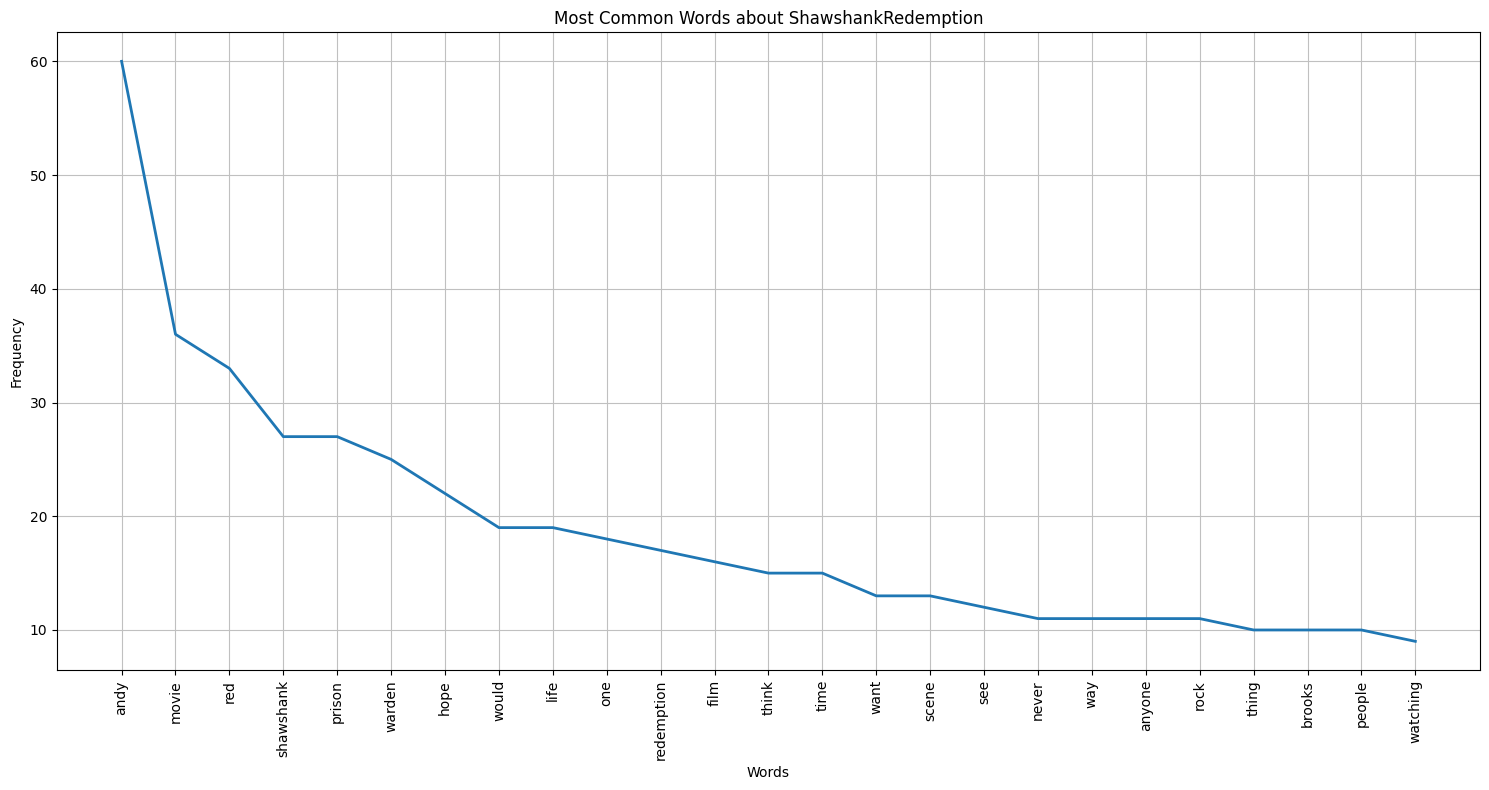

In [17]:
for movie in movie_subreddits:
    fdist_movie = fdist_series[movie]
    
    plt.figure(figsize=(15, 8))
    fdist_movie.plot(25)  # plot top 25 words
    plt.title(f"Most Common Words about {movie}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig('images/' + movie + '_freqlinegraph.png')
    plt.show()

In [ ]:
for movie in movie_subreddits:
    fdist_movie = fdist_series[movie].most_common(25)  # top 25 words
    
    # Separate words and counts for plotting
    words, counts = zip(*fdist_movie)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.bar(words, counts, color='skyblue')
    ax.set_title(f"Most Common Words about {movie}", fontsize=16)
    ax.set_xlabel("Words", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig('images/' + movie + '_freqbargraph.png')
    plt.show()

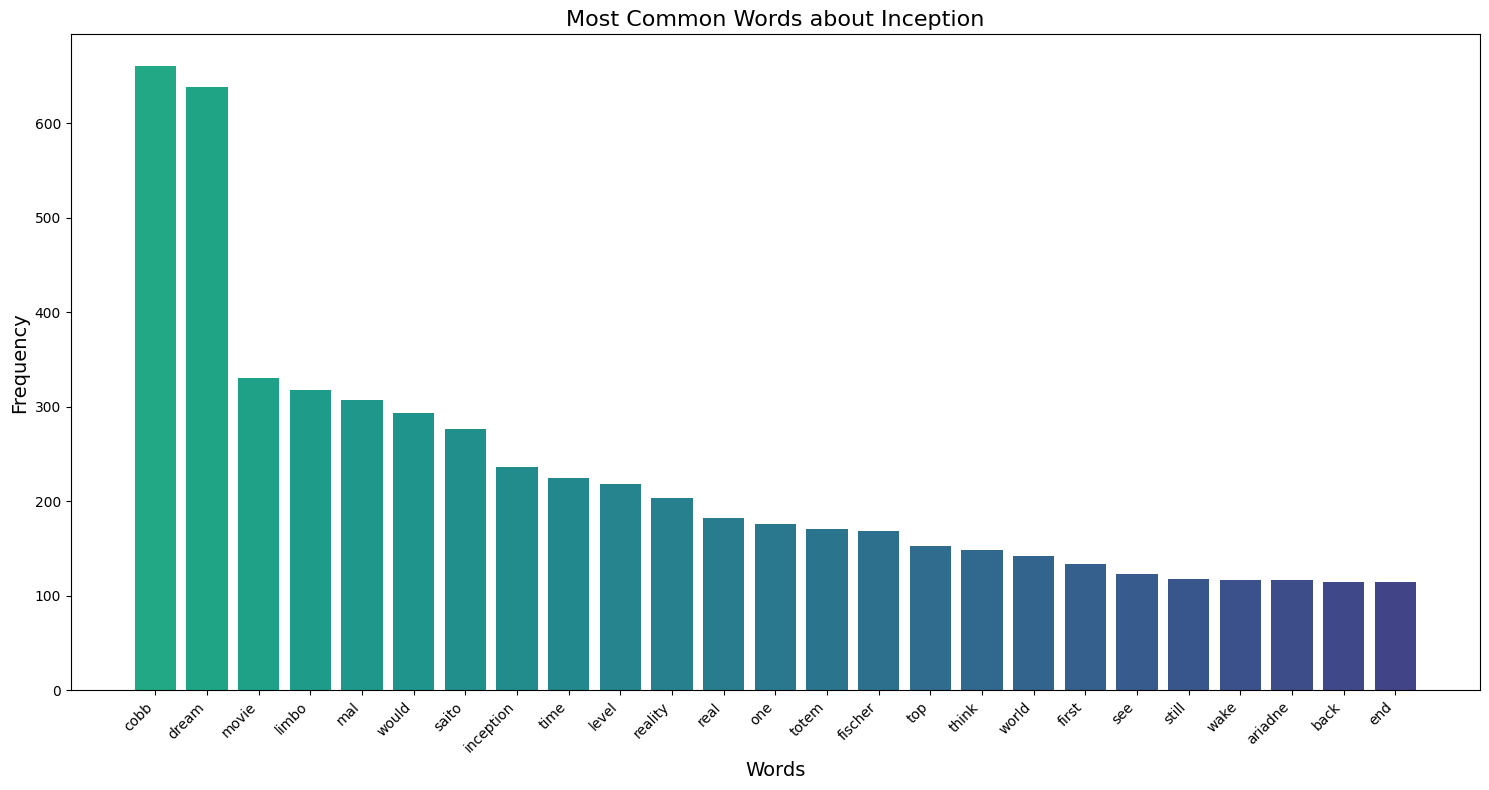

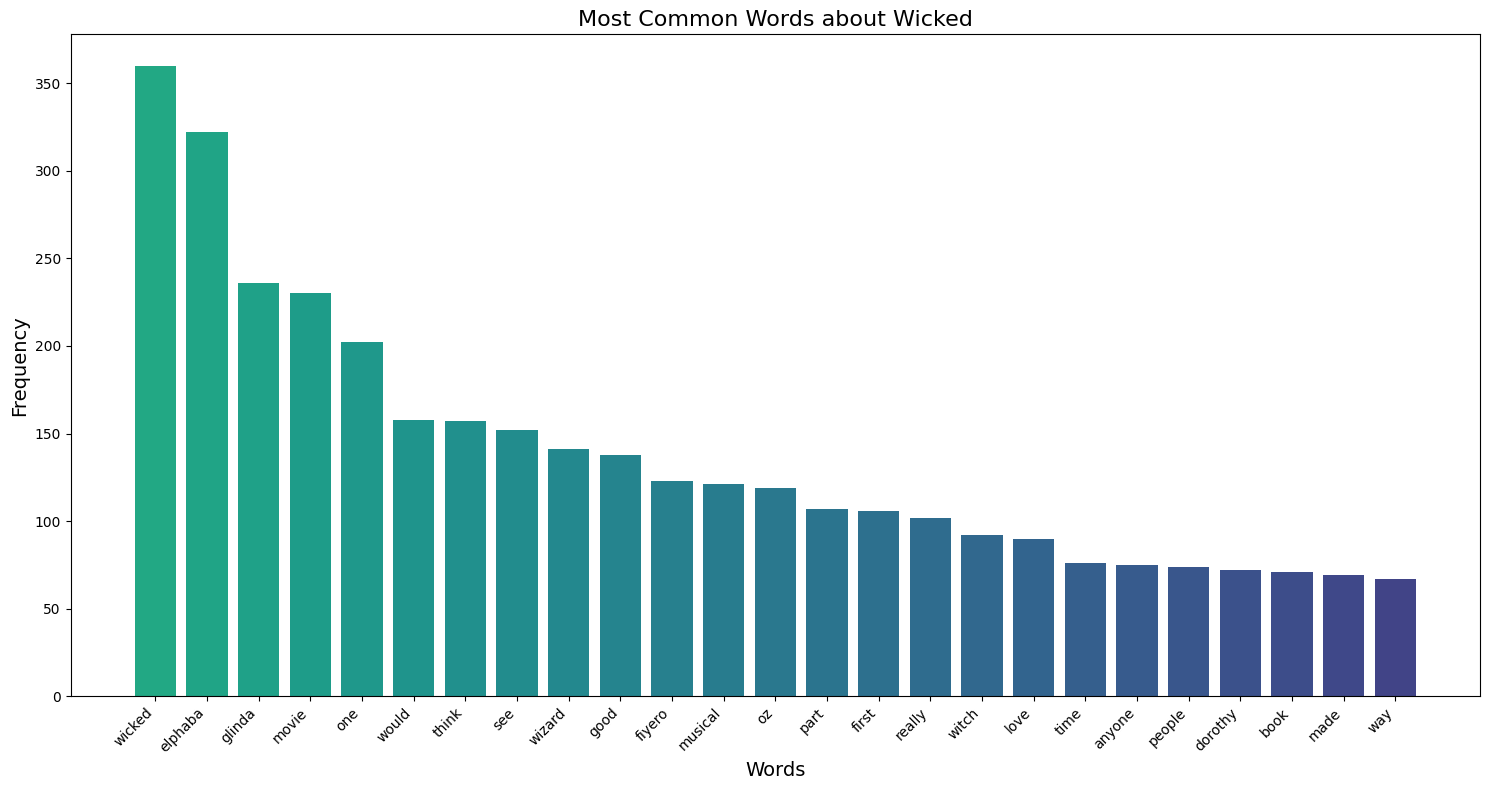

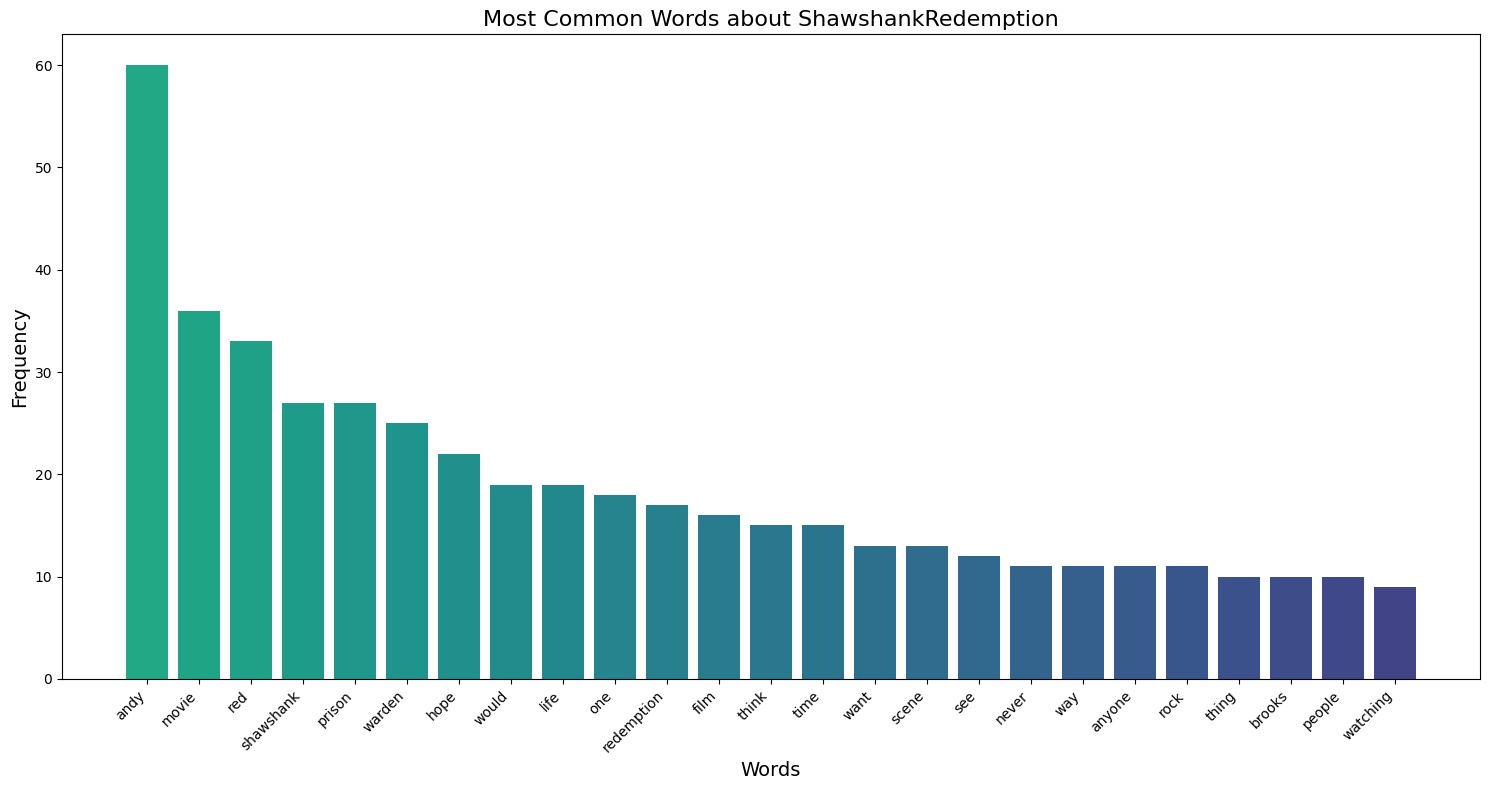

In [18]:
for movie in movie_subreddits:
    fdist_movie = fdist_series[movie].most_common(25)
    # Separate words and counts for plotting
    words, counts = zip(*fdist_movie)
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Create a color gradient for the bars
    colors = cm.viridis_r(np.linspace(0.4, 0.8, len(words)))
    
    ax.bar(words, counts, color=colors)
    ax.set_title(f"Most Common Words about {movie}", fontsize=16)
    ax.set_xlabel("Words", fontsize=14)
    ax.set_ylabel("Frequency", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('images/' + movie + '_topwordsgraph.png')
    plt.show()

In [ ]:
# Generate word clouds for each subreddit/movie
for movie in movie_subreddits:
    fdist_movie = fdist_series[movie]
    top_100_dict = dict(fdist_movie.most_common(100))
    
    wordcloud = WordCloud(
        colormap='twilight_shifted',
        background_color='black',
        width=800,
        height=800
    ).generate_from_frequencies(top_100_dict)
    
    plt.figure(figsize=(10, 10), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    
    # Uncomment the next line if you want to save your image:
    plt.savefig('images/' + movie + '_wordcloud.jpg')
    plt.show()

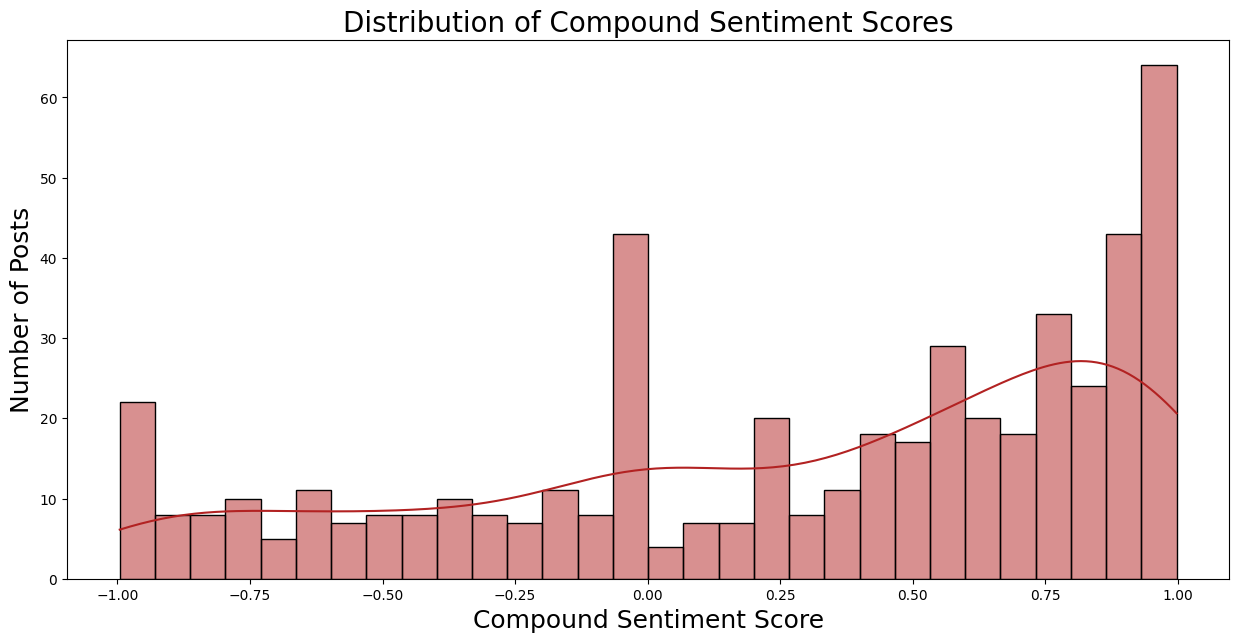

In [19]:
# Plot the distribution
plt.figure(figsize=(15,7))
sns.histplot(inception['compound_sentiment_score'].dropna(), color='firebrick', bins=30, kde=True)
plt.xlabel('Compound Sentiment Score', fontsize=18)
plt.ylabel('Number of Posts', fontsize=18)
plt.title('Distribution of Compound Sentiment Scores', fontsize=20)
plt.show()

# plt.savefig('Reddit_NLP_Sentiment/images/VADERinception.jpg')

In [ ]:
# Generate sentiment bar plots for each movie subreddit
for movie in movie_subreddits:
    movie_df = movies_df[movies_df['movie_subreddit'] == movie]

    avg_scores = {
        'Negative': movie_df['negative_sentiment_score'].mean(),
        'Neutral': movie_df['neutral_sentiment_score'].mean(),
        'Positive': movie_df['positive_sentiment_score'].mean()
    }

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.bar(avg_scores.keys(), avg_scores.values(), color=['red', 'yellow', 'green'])
    plt.title(f'{movie} VADER Sentiments', fontsize=25)
    plt.xlabel('Sentiment Classifications', fontsize=20)
    plt.ylabel('Average Score', fontsize=20)
    plt.tick_params(labelsize='large')
    
    # Uncomment the next line if you want to save your image:
    plt.savefig('images/' + movie + '_sentiments.jpg')
    plt.show()

## LDA & TSNE

In [ ]:
#stemmed tweets
ps = PorterStemmer()

In [ ]:
movies_df["stemmed_review"] = movies_df["filtered_review"].apply(
    lambda tokens: [ps.stem(re.sub(f"[{re.escape(string.punctuation)}]", "", word)) for word in tokens if re.sub(f"[{re.escape(string.punctuation)}]", "", word)]
)

In [ ]:
movies_df.head(3)

In [ ]:
# Join stemmed words per document into a single string
stemmed_words = movies_df["stemmed_review"].apply(lambda tokens: " ".join(tokens))

# Vectorize
vec = CountVectorizer(stop_words=list(stopwords_list))
X = vec.fit_transform(stemmed_words)

# Create DataFrame from the DTM
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())

print(df.shape)
df.head()

In [ ]:
#dictionary of numbers to words
dictionary = corpora.Dictionary(inception["stemmed_review"])
type(dictionary)
len(dictionary)

In [ ]:
dictionary[1]

In [ ]:
#bag of words (tokenid, tokencount)
corpus = [dictionary.doc2bow(d) for d in inception['stemmed_review']]

In [53]:
# corpus[:1]

In [ ]:
#running LDA model
lda = models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=5, passes=10)
lda.print_topics()

In [29]:
#clarifying LDA model
topics_data = []
for elem in lda.print_topics(-1):
    print("Topic", elem[0], "\nWords:", elem[1])
    topics_data.append([elem[0], elem[1]])

topics_df = pd.DataFrame(topics_data, columns=['Topic Number', 'Words'])

Topic 0 
Words: 0.042*"dream" + 0.011*"real" + 0.011*"cobb" + 0.010*"peopl" + 0.010*"wake" + 0.008*"realiti" + 0.007*"movi" + 0.007*"limbo" + 0.006*"machin" + 0.006*"one"
Topic 1 
Words: 0.027*"dream" + 0.009*"totem" + 0.009*"movi" + 0.007*"incept" + 0.006*"use" + 0.006*"would" + 0.005*"drug" + 0.005*"see" + 0.005*"one" + 0.005*"make"
Topic 2 
Words: 0.017*"incept" + 0.016*"movi" + 0.016*"fischer" + 0.010*"dream" + 0.008*"one" + 0.008*"time" + 0.008*"father" + 0.007*"think" + 0.007*"cobb" + 0.007*"charact"
Topic 3 
Words: 0.033*"cobb" + 0.028*"dream" + 0.012*"saito" + 0.010*"movi" + 0.008*"mal" + 0.008*"think" + 0.007*"incept" + 0.007*"limbo" + 0.006*"would" + 0.006*"time"
Topic 4 
Words: 0.025*"cobb" + 0.022*"dream" + 0.016*"limbo" + 0.014*"mal" + 0.012*"level" + 0.011*"would" + 0.010*"time" + 0.010*"saito" + 0.009*"movi" + 0.009*"realiti"


In [ ]:
pd.set_option('display.max_colwidth', None)
display(topics_df)

In [62]:
# Display model
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis)  # if you're in Jupyter Notebook

In [67]:
vis
pyLDAvis.save_html(vis, 'lda_visualization.html')

https://github.com/openai/openai-python

In [10]:
#Need to pay

In [15]:
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key = config["OPENAI_API_KEY"],
)

response = client.responses.create(
    model="gpt-4o",
    instructions="You are a coding assistant that talks like a pirate.",
    input="How do I check if a Python object is an instance of a class?",
)

# print(response.output_text)

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

In [16]:
from openai import OpenAI

client = OpenAI(api_key= config['reddit_sentiment'], base_url="https://api.deepseek.com")

response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": "You are a helpful assistant"},
        {"role": "user", "content": "Hello"},
    ],
    stream=False
)

print(response.choices[0].message.content)

APIStatusError: Error code: 402 - {'error': {'message': 'Insufficient Balance', 'type': 'unknown_error', 'param': None, 'code': 'invalid_request_error'}}

In [4]:
from gpt4all import GPT4All

https://docs.gpt4all.io/index.html

In [5]:
%%time
from gpt4all import GPT4All
model = GPT4All("Meta-Llama-3-8B-Instruct.Q4_0.gguf") # this line downloads for you / loads a 4.66GB LLM
with model.chat_session():
    print(model.generate("How can I run LLMs efficiently on my laptop?", max_tokens=1024))

Large Language Models (LLMs) are powerful AI models that require significant computational resources to train and run. However, with some optimization techniques and careful planning, you can still run LLMs efficiently on your laptop. Here are some tips to help you:

1. **Choose the right model**: Not all LLMs are created equal. Look for smaller models like BERT-base or DistilBERT that require less computational resources compared to larger models like RoBERTa-Large.
2. **Use a GPU (if available)**: If your laptop has a dedicated graphics card, you can use it to accelerate computations. This will significantly reduce the time required to run LLMs. You'll need to install CUDA or cuDNN drivers and configure your environment accordingly.
3. **Optimize Python code**: Use optimized libraries like NumPy, SciPy, and scikit-learn for numerical computations. These libraries are designed to be fast and efficient.
4. **Use a just-in-time (JIT) compiler**: JIT compilers can significantly improve t

In [8]:
%%time
prompt = """
Here are 5 topics from an LDA model on Reddit posts about the movie Inception.
Each topic contains its top words. Give each topic a short descriptive label.

Topic 0: dream, real, cobb, peopl, wake, realiti, movi, limbo, machin, one
Topic 1: dream, totem, movi, incept, use, would, drug, see, one, make  
Topic 2: incept, movi, fischer, dream, one, time, father, think, cobb, charact
Topic 3: cobb, dream, saito, movi, mal, think, incept, limbo, would, time
Topic 4: cobb, dream, limbo, mal, level, would, time, saito, movi, realiti
"""

model.generate(prompt)

CPU times: total: 13min
Wall time: 3min 19s


'The descriptive labels for each topic are:\n0. The concept of reality vs. dreams (e.g., "what\'s the difference between a dream and waking life?")\n1. Dream manipulation techniques used in Inception (e.g., totems, drugs)\n2. Character analysis and relationships within the movie (e.g., Cobb-Fischer dynamics)\n3. Themes related to memory, identity, and the blurring of reality\n4. The mechanics of dreaming and levels within dreams\n\nThese topics can be seen as a way to categorize or group similar ideas expressed in the Reddit posts about Inception.\nThe top words for each topic are those that appear most frequently across all documents (posts) assigned to that topic, which gives us an idea of what these groups of related ideas have in common.  The descriptive labels provide additional context and help readers understand the content of each group.\n\nNote: LDA stands for Latent Dirichlet Allocation, a popular unsupervised machine learning algorithm used for topic'

# T-SNE

In [63]:
print(range(len(corpus)))
#LDA matrix results
X = []
for i in range(len(corpus)):
    if len(lda[corpus[i]]) == 5:
        X.append([y for (x,y) in lda[corpus[i]]])       
# X

range(0, 308)


In [64]:
#reduce dimensionality
tsne = TSNE(n_components=2, random_state=27)
embedding = tsne.fit_transform(np.array(X))
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = np.array(X).argmax(axis=1)

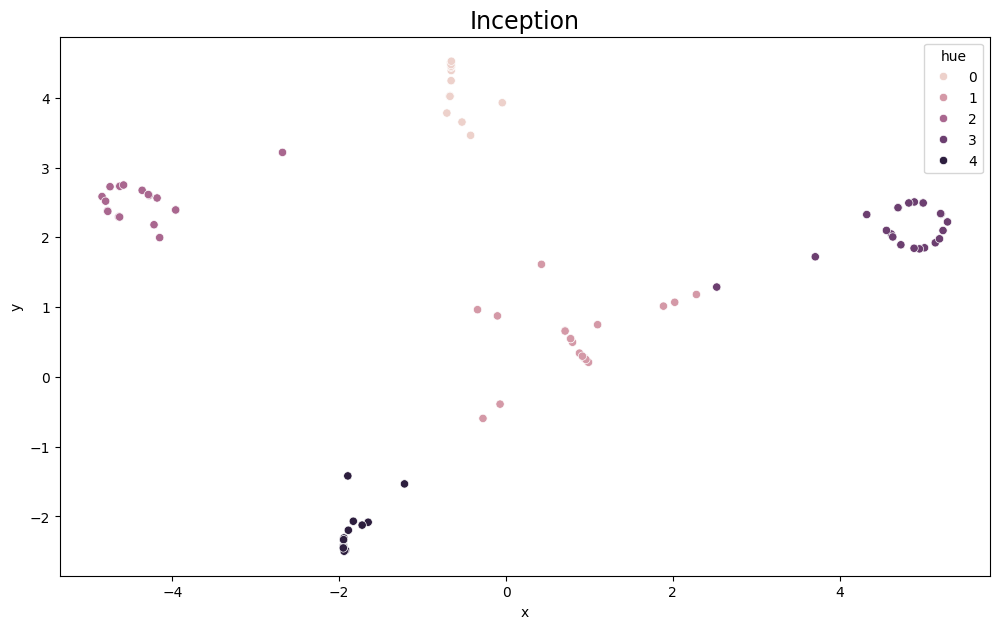

In [65]:
# plot of reduced dimensionality for Inception
fig, ax = plt.subplots(figsize =(12,7))
sns.scatterplot(
    x = "x", y="y",
    hue="hue",
    ax = ax,
    data=embedding)
plt.title('Inception', fontsize = 17)
plt.savefig('images/tsne_inception.jpg')